In [1]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [6]:
with open('dataset.pickle', 'rb') as f:
    X, X_test, y, feature_names, n_features, n_samples = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('subsets.pickle', 'rb') as f:
    is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, is_high_proba_diff, is_low_proba_diff = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b, is_log_odds_finite = pickle.load(f)

In [4]:
try:
    with open('shapvalues.proba.pickle', 'rb') as f:
        shap_proba_diff, shap_proba_diff_a_pos, shap_proba_diff_b_pos, overall_importance, feature_order, shap_proba_diff_a_vs_b_pos = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

No cached shap values found


In [5]:
try:
    with open('dataset.explain.pickle', 'rb') as f:
        background_data, X_explain, is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, is_high_proba_diff, is_low_proba_diff = pickle.load(f)
        print('Loaded cached dataset')
except FileNotFoundError:
    print('No cached dataset found')

No cached dataset found


First, we take a sample of each part of the dataset to reduce calculation time

In [8]:
X_clean = X[is_log_odds_finite]
background_data = X_clean

idx_pred_diff = np.where(is_pred_diff & is_log_odds_finite)[0]
idx_high_proba_diff = np.where(is_high_proba_diff & is_log_odds_finite)[0]
idx_low_proba_diff = np.where(is_low_proba_diff & is_log_odds_finite)[0]

if len(idx_pred_diff) > 250:
    idx_pred_diff = resample(idx_pred_diff, stratify=is_pred_diff_a_pos[idx_pred_diff], n_samples=250, replace=False, random_state=0)
if len(idx_high_proba_diff) > 250:
    idx_high_proba_diff = resample(idx_high_proba_diff, n_samples=250, replace=False, random_state=0)
if len(idx_low_proba_diff) > 250:
    idx_low_proba_diff = resample(idx_low_proba_diff, n_samples=250, replace=False, random_state=0)

In [12]:
idx_to_explain = np.sort(np.concatenate((idx_pred_diff, idx_high_proba_diff, idx_low_proba_diff)))
X_explain = X[idx_to_explain, :]

In [13]:
is_pred_diff = is_pred_diff[idx_to_explain]
is_pred_diff_a_pos = is_pred_diff_a_pos[idx_to_explain]
is_pred_diff_b_pos = is_pred_diff_b_pos[idx_to_explain]
is_high_proba_diff = is_high_proba_diff[idx_to_explain]
is_low_proba_diff = is_low_proba_diff[idx_to_explain]

In [14]:
with open('dataset.explain.pickle', 'wb') as f:
    pickle.dump((background_data, X_explain, is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, is_high_proba_diff, is_low_proba_diff), f, pickle.HIGHEST_PROTOCOL)

Now we define the difference functions to be explained:

In [15]:
merge_proba_diff_c1_pos = lambda p1, p2: p1[:, 1] * p2[:, 0]
predict_proba_diff_a_pos = lambda X: merge_proba_diff_c1_pos(clf_a.predict_proba(X), clf_b.predict_proba(X))
predict_proba_diff_b_pos = lambda X: merge_proba_diff_c1_pos(clf_b.predict_proba(X), clf_a.predict_proba(X))

In [16]:
merge_proba_diff = lambda p1, p2: merge_proba_diff_c1_pos(p1, p2) + merge_proba_diff_c1_pos(p2, p1)
predict_proba_diff = lambda X: merge_proba_diff(clf_a.predict_proba(X), clf_b.predict_proba(X))

And now we calculate SHAP values for each merge function:

In [17]:
def explain(predict, background_data):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X_explain)
    return shap_values

In [18]:
%%time
shap_proba_diff = explain(predict_proba_diff, background_data)
shap_proba_diff_a_pos = explain(predict_proba_diff_a_pos, background_data)
shap_proba_diff_b_pos = explain(predict_proba_diff_b_pos, background_data)

overall_importance = shap_proba_diff.abs.mean(axis=0)
feature_order = np.flip(overall_importance.values.argsort())

shap_proba_diff_a_vs_b_pos = shap_proba_diff_b_pos - shap_proba_diff_a_pos
shap_proba_diff_a_vs_b_pos.data = shap_proba_diff_a_pos.data
shap_proba_diff_a_vs_b_pos.display_data = shap_proba_diff_a_pos.display_data

with open(f'shapvalues.proba.pickle', 'wb') as f:
    pickle.dump((shap_proba_diff, shap_proba_diff_a_pos, shap_proba_diff_b_pos, overall_importance, feature_order, shap_proba_diff_a_vs_b_pos), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 5.09 s, sys: 70.4 ms, total: 5.16 s
Wall time: 5.43 s


## Analyze

### Feature Importance

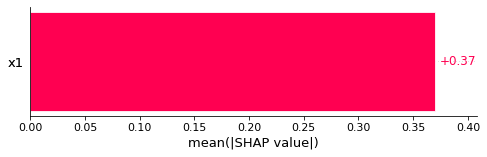

In [53]:
shap.plots.bar(overall_importance, max_display=n_features)

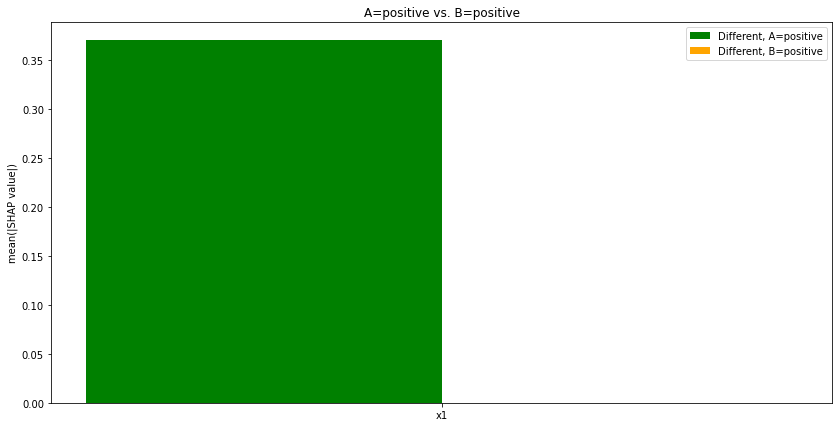

In [57]:
labels = feature_names

x = np.arange(n_features)
width = 0.2

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, shap_proba_diff_a_pos.abs.mean(0)[feature_order].values, width, label='Different, A=positive', color='green')
rects2 = ax.bar(x + width/2, shap_proba_diff_b_pos.abs.mean(0)[feature_order].values, width, label='Different, B=positive', color='orange')
ax.set_ylabel('mean(|SHAP value|)')
ax.set_title('A=positive vs. B=positive')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

### SHAP Value Distribution

Next, we will try to understand the importances using the whole distribution of values, not only the aggregated mean.

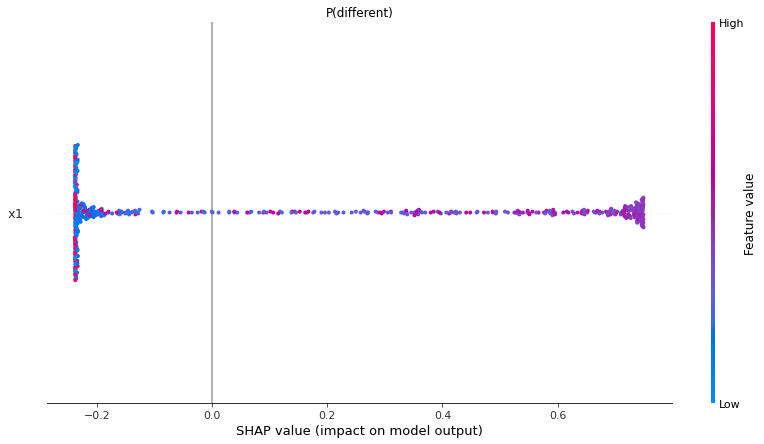

In [39]:
plot.shap_beeswarm(shap_proba_diff, 'P(different)', order=feature_order, max_display=n_features)

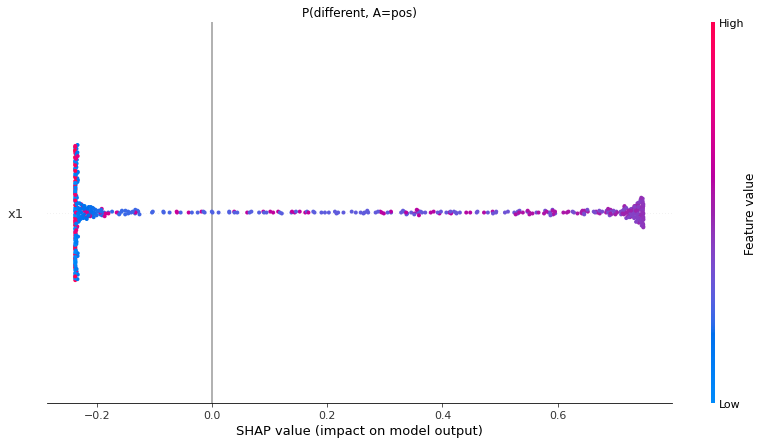

In [41]:
plot.shap_beeswarm(shap_proba_diff_a_pos, 'P(different, A=pos)', order=feature_order, max_display=n_features)

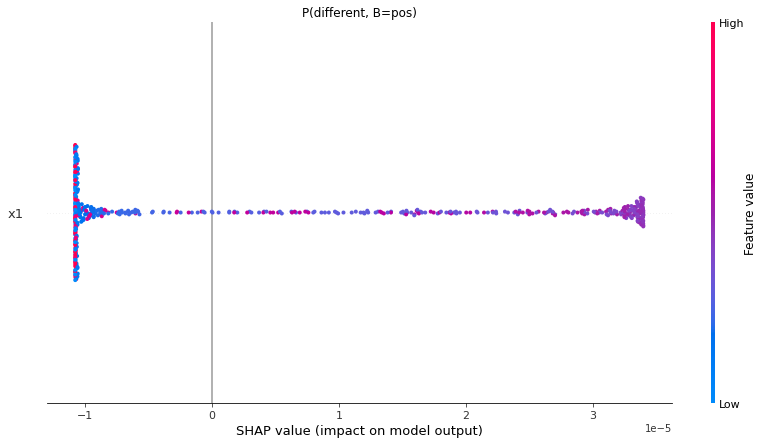

In [42]:
plot.shap_beeswarm(shap_proba_diff_b_pos, 'P(different, B=pos)', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

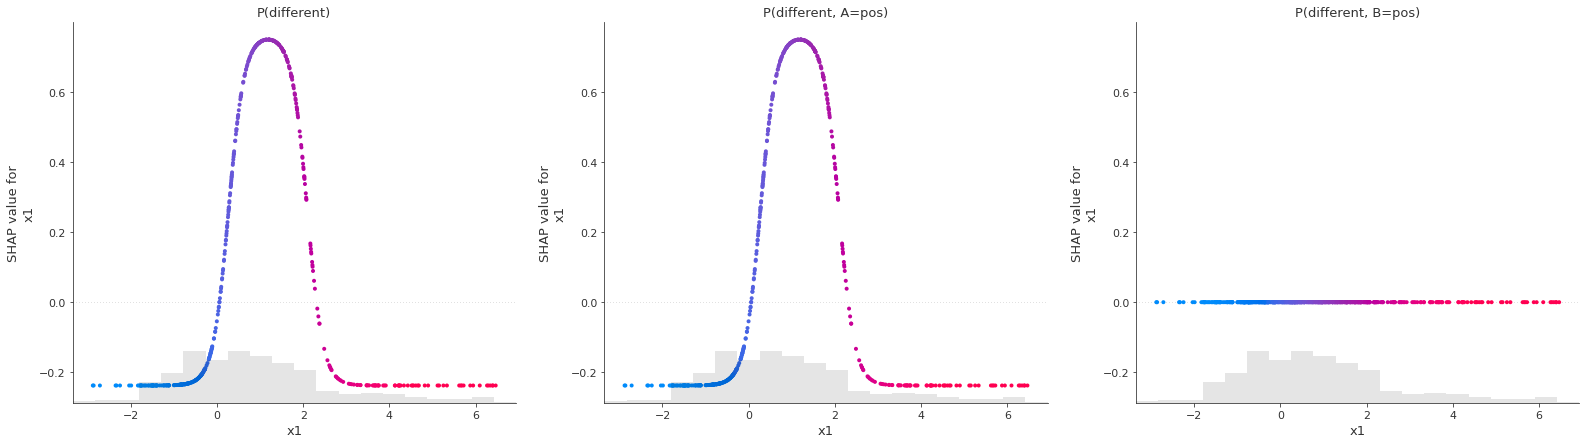

In [44]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(shap_proba_diff, feature, 'P(different)', ax=ax)
    plot.shap_scatter(shap_proba_diff_a_pos, feature, 'P(different, A=pos)', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    plot.shap_scatter(shap_proba_diff_b_pos, feature, 'P(different, B=pos)', ax=fig.add_subplot(n_rows, n_columns, i+2, sharey=ax))
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [52]:
plot.shap_force(shap_proba_diff, 'P(different)');

In [47]:
plot.shap_force(shap_proba_diff_a_pos, 'P(different, A=pos)')
plot.shap_force(shap_proba_diff_b_pos, 'P(different, B=pos)');

### Hierarchically Clustered SHAP Values

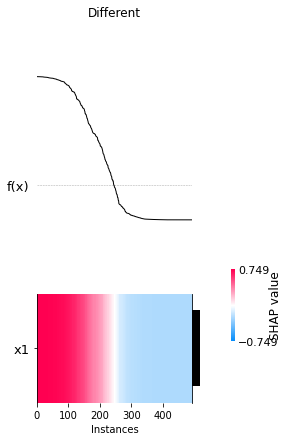

In [50]:
plot.shap_heatmap(shap_proba_diff, 'Different', feature_order)

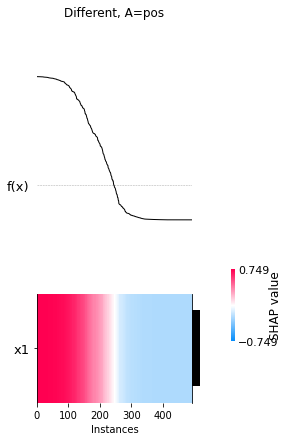

In [48]:
plot.shap_heatmap(shap_proba_diff_a_pos, 'Different, A=pos', feature_order)

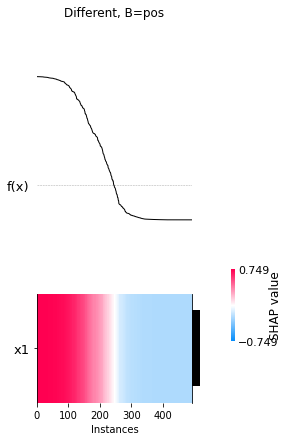

In [49]:
plot.shap_heatmap(shap_proba_diff_a_pos, 'Different, B=pos', feature_order)